In [2]:
from collections import defaultdict
import itertools
import numpy as np

from benchmark import benchmark_chains
import blackjax
from blackjax.util import run_inference_algorithm
from sampling_algorithms import samplers
from inference_models import models
import jax.numpy as jnp
import math
import pandas as pd


In [106]:
def sampler_mclmc(step_size, L, noise):
    def s(logdensity_fn, num_steps, initial_position, key):
        alg = blackjax.mclmc(
        logdensity_fn=logdensity_fn,
        step_size=step_size,
        L=L,
        noise=noise
        )
        _, out, info = run_inference_algorithm(
        rng_key=key,
        initial_state_or_position=initial_position,
        inference_algorithm=alg,
        num_steps=num_steps, 
        transform=lambda x: x.position, 
        progress_bar=True)
        return out, 1

    return s

batch_size = 20
results = defaultdict(float)
for model in ["Banana"]:
    for step_size, L, noise, N in itertools.product([1.005], [16.765137], [1., 2.], np.linspace(100000.,2000000., 8)):
        N = N.astype(int)
        _, bias = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=N, fvar=jnp.array([20000.0, 4600.898]), favg=jnp.array([100.0, 19.0])) #not using fvar and favg
        results[(model, step_size, L, noise, N)] = bias

for model in ["Banana"]:
    for step_size, L, noise, N in itertools.product([1.005], [16.765137], np.linspace(1e-1, 2, 20), [1000000]):
        _, bias = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=N, fvar=jnp.array([20000.0, 4600.898]), favg=jnp.array([100.0, 19.0])) #not using fvar and favg
        results[(model, step_size, L, noise, N)] = bias

for model in ["Banana"]:
    for step_size, L, noise, N in itertools.product(np.linspace(0.1,2, 10), [16.765137], [0.0], [1000000]):
        _, bias = benchmark_chains(models[model], sampler_mclmc(step_size, L, noise), batch=batch_size, n=N, fvar=jnp.array([20000.0, 4600.898]), favg=jnp.array([100.0, 19.0])) #not using fvar and favg
        results[(model, step_size, L, noise, N)] = bias

In [96]:
df = pd.Series(results).reset_index()
df.columns = ["model", "step_size", "L", "noise", "N", "bias"] 

/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


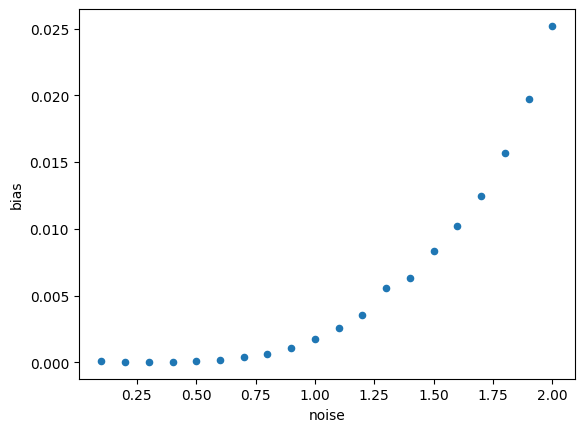

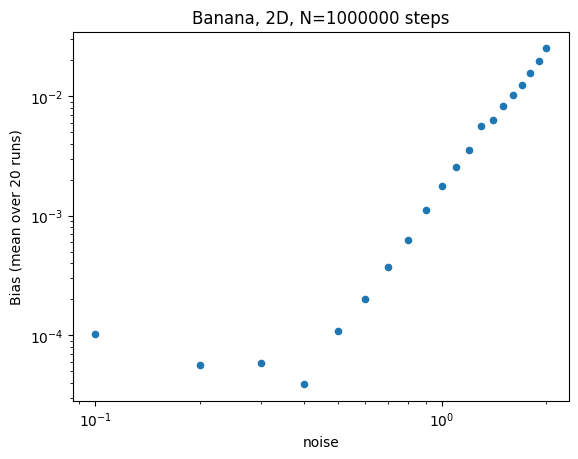

In [104]:
N = 1000000
df_1 = df[df.N==N]
df_1 = df_1[df_1.model=="Banana"]
df_1 = df_1[df_1.step_size==1.005]
df_1 = df_1[df_1.L==16.765137]
df_1

df_1.plot.scatter(x="noise", y="bias", colormap='viridis', )
df_1.plot.scatter(x="noise", y="bias", colormap='viridis', loglog=True)
plt.xlabel('noise')
plt.ylabel(f'Bias (mean over {batch_size} runs)')
plt.title(f'Banana, 2D, N={N} steps')
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(
/opt/homebrew/Caskroom/miniconda/base/envs/mclmc/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1266: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


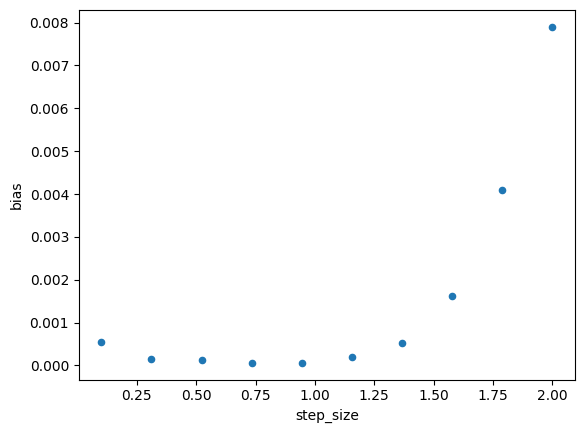

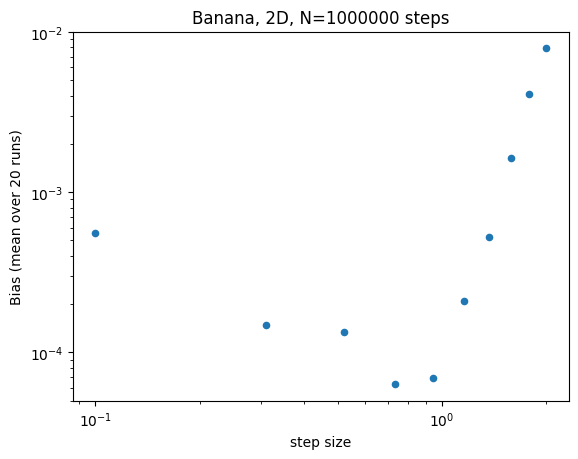

In [105]:
N = 1000000
df_2 = df[df.N==N]
df_2 = df_2[df_2.model=="Banana"]
df_2 = df_2[df_2.noise==0.0]
df_2 = df_2[df_2.L==16.765137]
df_2

df_2.plot.scatter(x="step_size", y="bias", colormap='viridis')
df_2.plot.scatter(x="step_size", y="bias", colormap='viridis', loglog=True)
plt.xlabel('step size')
plt.ylabel(f'Bias (mean over {batch_size} runs)')
plt.title(f'Banana, 2D, N={N} steps')
plt.show()


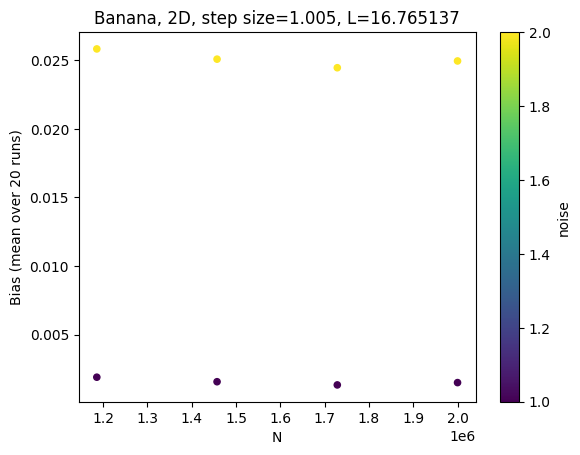

In [102]:
df_3 = df
df_3 = df_3[df_3['N'] > 1000000]
df_3 = df_3[df_3.model=="Banana"]
df_3 = df_3[df_3.step_size==1.005]
df_3 = df_3[df_3.L==16.765137]
df_3


df_3.plot.scatter(x="N", y="bias", colormap='viridis', c='noise')
plt.xlabel('N')
plt.ylabel(f'Bias (mean over {batch_size} runs)')
plt.title(f'Banana, 2D, step size=1.005, L=16.765137')
plt.show()

In [ ]:
results = defaultdict(float)

for model in ["Banana"]:
    for sampler in ["mclmc"]:
    # for step_size in []:
    # for sampler in itertools.product(np.linspace(1e-3, 1e0, 10), np.linspace(5,50, 10)):
        # result = benchmark(models[model], samplers[sampler])
        # result = benchmark_chains(models[model], samplers[sampler])
        result = benchmark_chains(models[model], samplers[sampler], batch=20, n = 100000)
        # print(result, result2, "results")
        results[(model, sampler)] = result

results